In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_addons as tfa
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix
import seaborn as sns

from datetime import datetime

print(tf.__version__)
tf.config.list_physical_devices('GPU')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.9.1
1 Physical GPUs, 1 Logical GPUs


2022-11-26 10:05:17.263401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 10:05:17.279410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 10:05:17.279679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 10:05:17.280984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
(ds_train, ds_test, ds_validation), ds_info = tfds.load(
    'eurosat/all',
    split=['train[:80%]','train[80%:90%]','train[90%:100%]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [3]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['sparse_categorical_accuracy']
    val_accuracy = training_history.history['val_sparse_categorical_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.savefig(fname="EfficientNetB4/EfficientNetB4 history"+current_time,dpi=300)

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return image[:,:,1:4]/28002., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

ds_validation = ds_validation.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_validation = ds_validation.batch(128)
ds_validation = ds_validation.cache()

In [5]:
def preview_dataset(dataset):
    for image, label in dataset.take(20):
        print(image)
#preview_dataset(ds_test)

In [6]:
#FLIP
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image
# AUGMENT COLOR
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.07)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_hue(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.062)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_saturation(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_saturation(image, lower=0.745, upper=1.25)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_brightness(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_brightness(image, 0.062)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_contrast(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_contrast(image, lower=0.85, upper=1.05)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
# ROTATE
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )
#INVERT
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.8:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [7]:
def augment_data(image,label):
  image=augment_flip(image)
  #image=augment_color(image)
  #image=augment_rotation(image)
  #image=augment_inversion(image)
  image=augment_hue(image)
  image=augment_saturation(image)
  image=augment_brightness(image)
  image=augment_contrast(image)


  return image,label

In [8]:
ds_train_augmented = ds_train.map(augment_data)

In [9]:
resnet = tf.keras.applications.EfficientNetB4(include_top = False,
                                          input_shape = (64,64,3),
                                          classes = 10)

model = tf.keras.models.Sequential(resnet)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

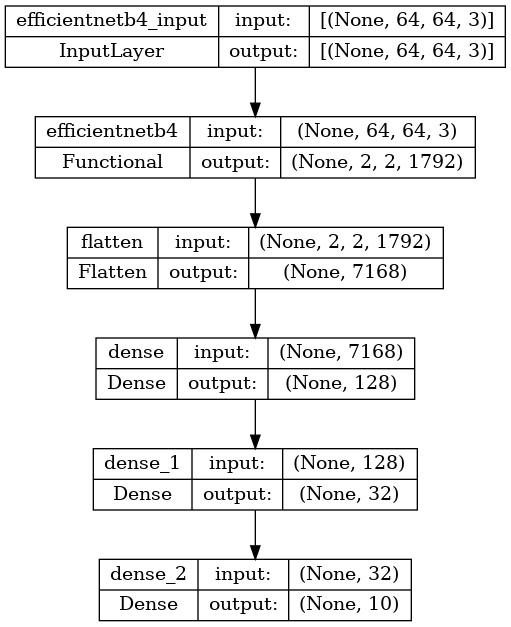

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-7),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [ ]:
history = model.fit(
    ds_train_augmented,
    epochs=100,
    validation_data=ds_validation,
    callbacks = tf.keras.callbacks.ModelCheckpoint(
        "EfficientNetB4/EfficientNetB4 epoch:{epoch:02d}-val_loss:{val_loss:.3f}",
        save_best_only = True,
        initial_value_threshold = 0.7
    )
)

Epoch 1/100


2022-11-26 10:05:33.350741: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-26 10:05:34.430673: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.73GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-26 10:05:34.485478: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-26 10:05:34.638329: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains

168/169 [============================>.] - ETA: 0s - loss: 2.5542 - sparse_categorical_accuracy: 0.0953

2022-11-26 10:06:23.576558: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.70GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-26 10:06:23.627708: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-26 10:06:23.678260: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


169/169 [==============================] - 67s 312ms/step - loss: 2.5533 - sparse_categorical_accuracy: 0.0956 - val_loss: 2.3776 - val_sparse_categorical_accuracy: 0.1070
Epoch 2/100
169/169 [==============================] - 50s 294ms/step - loss: 2.4718 - sparse_categorical_accuracy: 0.1073 - val_loss: 2.7825 - val_sparse_categorical_accuracy: 0.0781
Epoch 3/100
169/169 [==============================] - 50s 296ms/step - loss: 2.4070 - sparse_categorical_accuracy: 0.1275 - val_loss: 2.4392 - val_sparse_categorical_accuracy: 0.0948
Epoch 4/100
169/169 [==============================] - 50s 295ms/step - loss: 2.3460 - sparse_categorical_accuracy: 0.1505 - val_loss: 2.4827 - val_sparse_categorical_accuracy: 0.1356
Epoch 5/100
169/169 [==============================] - 50s 298ms/step - loss: 2.2828 - sparse_categorical_accuracy: 0.1811 - val_loss: 2.4938 - val_sparse_categorical_accuracy: 0.1189
Epoch 6/100
169/169 [==============================] - 50s 297ms/step - loss: 2.2366 - spars

In [ ]:
test_loss, test_acc = model.evaluate(ds_test, verbose=0)
print('\nTest accuracy:', test_acc)


ds_test_predict = model.predict(ds_test, verbose=0)

labels_iterator = ds_test.unbatch().map(lambda x, y: y).as_numpy_iterator()
labels = np.array(list(labels_iterator))

y_pred = np.argmax(ds_test_predict, axis=1)
y_test = labels
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_pred, y_test, normalize="pred"), annot=True, fmt=".2%",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['AnnualCrop','Forest','HerbaceousVegetation',
                         'Highway','Industrial','Pasture','PermanentCrop',
                         'Residential','River','SeaLake'], rotation=20, ha="right")
fx.yaxis.set_ticklabels(['AnnualCrop','Forest','HerbaceousVegetation',
                         'Highway','Industrial','Pasture','PermanentCrop',
                         'Residential','River','SeaLake'], rotation=20, ha="right")

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
plt.savefig(fname="EfficientNetB4/EfficientNetB4 confusion matrix"+current_time,dpi=300)
render_training_history(history)
